In [ ]:
from google.colab import drive
drive.mount

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')


In [3]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier # Added import for KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
ag_news_train=pd.read_csv('/content/train.csv') #reads reads csv file and stores ag_news_train

In [5]:
ag_news_train.head(4)

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...


In [6]:
ag_news_train.shape

(120000, 3)

In [7]:
ag_news_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [8]:
ag_news_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Class Index,120000.0,NaN,NaN,NaN,2.5,1.118039,1.0,1.75,2.5,3.25,4.0
Title,120000,114350,Today's schedule,39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,120000,118723,"With the economy slowly turning up, upgrading ...",15,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
ag_news_test=pd.read_csv('/content/test.csv')

In [10]:
ag_news_test.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [11]:
ag_news_test.shape

(7600, 3)

In [12]:
ag_news_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  7600 non-null   int64 
 1   Title        7600 non-null   object
 2   Description  7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.3+ KB


In [13]:
ag_news_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Class Index,7600.0,NaN,NaN,NaN,2.5,1.118108,1.0,1.75,2.5,3.25,4.0
Title,7600,7568,Today's schedule,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,7600,7594,WASHINGTON (Reuters) - The U.S. economy slowe...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
ag_news_train.isnull().sum()

,0
Class Index,0
Title,0
Description,0


In [15]:
ag_news_test.isnull().sum()

,0
Class Index,0
Title,0
Description,0


In [16]:
ag_news_train.duplicated().sum()

np.int64(0)

In [17]:
ag_news_test.duplicated().sum()

np.int64(0)

In [18]:
ag_news_train['Class Index'].value_counts()

,count
Class Index,
3,30000
4,30000
2,30000
1,30000


In [19]:
ag_news_test['Class Index'].value_counts() #counts how many rows belongs to each category(1,2,3,4)

,count
Class Index,
3,1900
4,1900
2,1900
1,1900


In [20]:
# Function to clean text
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.strip()  # remove leading whitespaces
    text = re.sub(r'\s+', ' ', text)  # replace multiple spaces/newlines/tabs with single space
    text = re.sub(r'\\[nrt]', ' ', text)  # remove literal \n, \r, \t
    text = re.sub(r'[^\w\s]', '', text)  # remove special characters except num/words ans spaces
    return text

In [21]:
# apply cleaning to both title and description
for df in [ag_news_train, ag_news_test]:
    df['Title'] = df['Title'].apply(clean_text)
    df['Description'] = df['Description'].apply(clean_text)

In [22]:
ag_news_train.duplicated().sum()

np.int64(115)

In [23]:
ag_news_train.drop_duplicates(inplace=True)

In [24]:
ag_news_train.reset_index(drop=True, inplace=True)

In [25]:
ag_news_train.duplicated().sum()

np.int64(0)

In [26]:
ag_news_test.duplicated().sum()

np.int64(0)

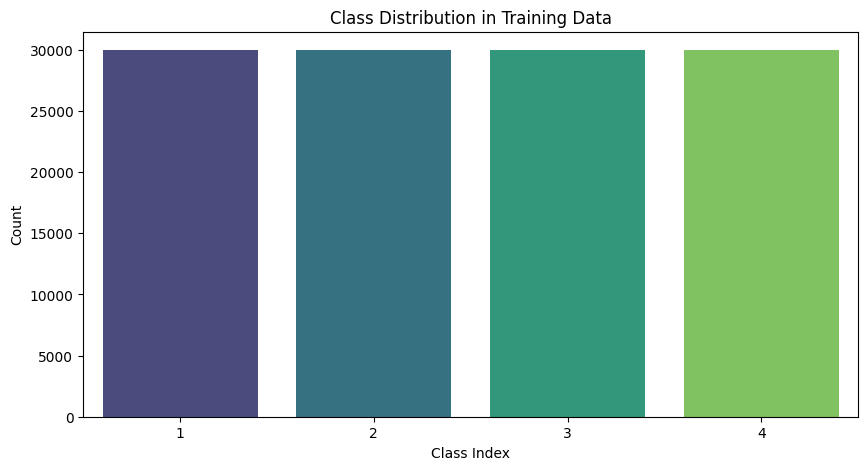

In [27]:
# Class Distribution
plt.figure(figsize=(10,5))
sns.countplot(x='Class Index', data=ag_news_train,palette='viridis')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.show()

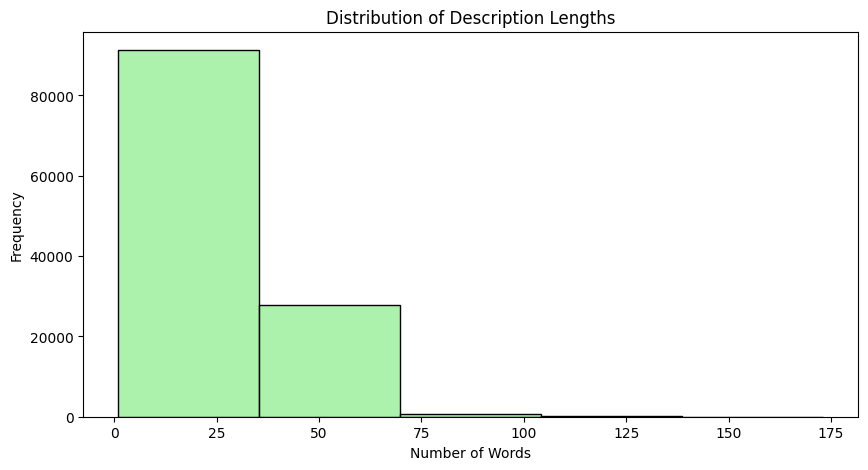

In [28]:
# Description length distribution
ag_news_train['desc_len'] = ag_news_train['Description'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,5))
sns.histplot(ag_news_train['desc_len'], bins=5, color='lightgreen')
plt.title('Distribution of Description Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

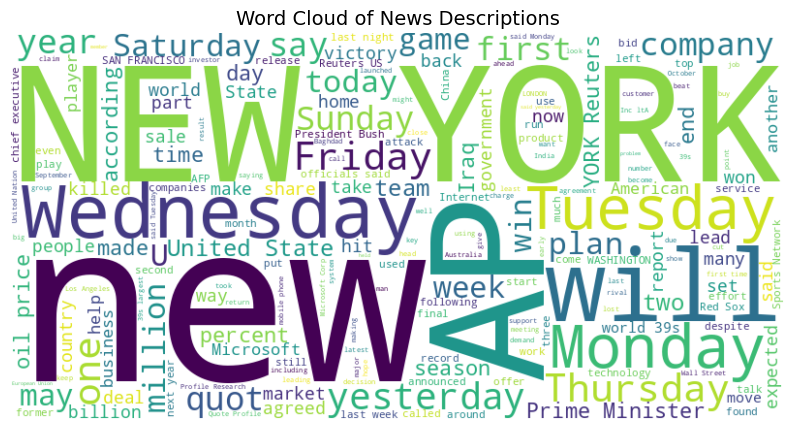

In [29]:
# combine all descriptions into one text
text_data = " ".join(ag_news_train['Description'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=200).generate(text_data)
# Plot Word Cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Descriptions', fontsize=14)
plt.show()

In [30]:
# Combine title + description
ag_news_train['text'] = ag_news_train['Title'] + " " + ag_news_train['Description']

In [31]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(ag_news_train['text'])
y = ag_news_train['Class Index']

In [32]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)

In [34]:
y_pred_rf = rf.predict(X_test)

In [35]:
# Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.8010176419068273


In [36]:
# Classification Report
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           1       0.88      0.76      0.82      5962
           2       0.79      0.94      0.86      5972
           3       0.81      0.73      0.77      5970
           4       0.73      0.78      0.75      6073

    accuracy                           0.80     23977
   macro avg       0.81      0.80      0.80     23977
weighted avg       0.81      0.80      0.80     23977



<Figure size 600x500 with 0 Axes>

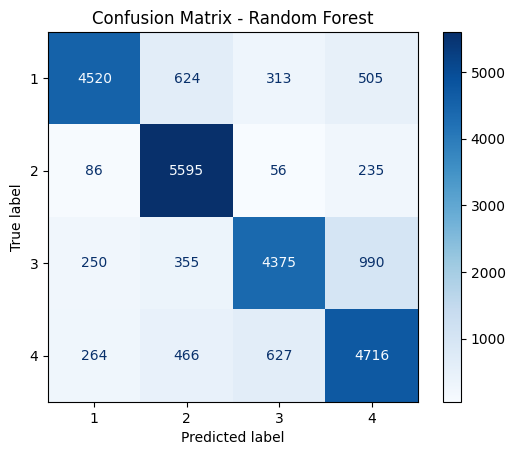

In [37]:
# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=sorted(y.unique()))
plt.figure(figsize=(6,5))
disp_rf.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Random Forest')
plt.show()

Random Forest Accuracy: 0.7786628852650457
              precision    recall  f1-score   support

           1       0.88      0.73      0.80      5962
           2       0.78      0.92      0.84      5972
           3       0.78      0.71      0.74      5970
           4       0.71      0.75      0.73      6073

    accuracy                           0.78     23977
   macro avg       0.78      0.78      0.78     23977
weighted avg       0.78      0.78      0.78     23977



<Figure size 600x500 with 0 Axes>

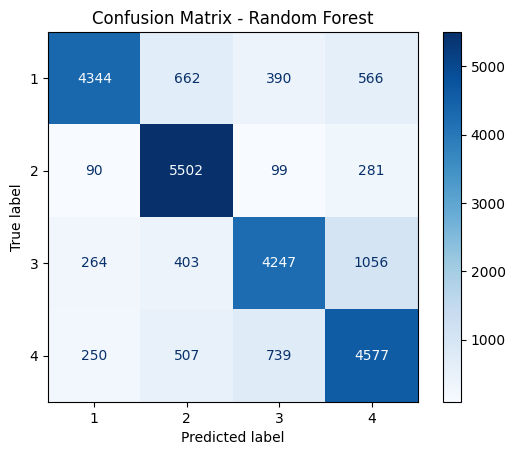

In [38]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
# Accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
# Classification Report
print(classification_report(y_test, y_pred_rf))
# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=sorted(y.unique()))
plt.figure(figsize=(6,5))
disp_rf.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [39]:
# KNN
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', weights='distance')

In [40]:
y_pred_knn = knn.predict(X_test)

In [41]:
# Accuracy
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))

KNN Accuracy: 0.8903949618384285


In [42]:
# Classification Report
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           1       0.90      0.89      0.90      5962
           2       0.94      0.96      0.94      5972
           3       0.86      0.86      0.86      5970
           4       0.86      0.86      0.86      6073

    accuracy                           0.89     23977
   macro avg       0.89      0.89      0.89     23977
weighted avg       0.89      0.89      0.89     23977



<Figure size 600x500 with 0 Axes>

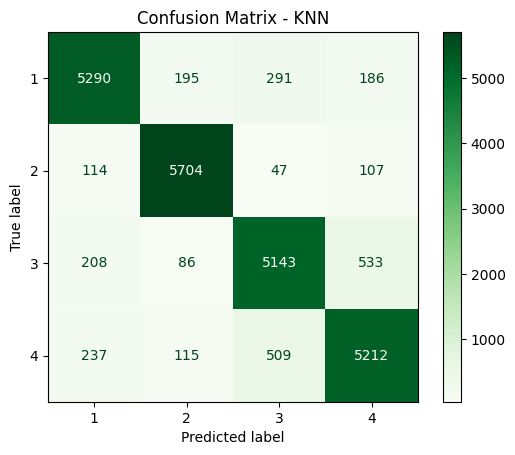

In [43]:
# Confusion Matrix - KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=sorted(y.unique()))
plt.figure(figsize=(6,5))
disp_knn.plot(cmap='Greens', values_format='d')
plt.title('Confusion Matrix - KNN')
plt.show()

KNN Accuracy: 0.8846811527714059
              precision    recall  f1-score   support

           1       0.89      0.88      0.89      5962
           2       0.94      0.94      0.94      5972
           3       0.85      0.86      0.86      5970
           4       0.86      0.85      0.86      6073

    accuracy                           0.88     23977
   macro avg       0.88      0.88      0.88     23977
weighted avg       0.88      0.88      0.88     23977



<Figure size 600x500 with 0 Axes>

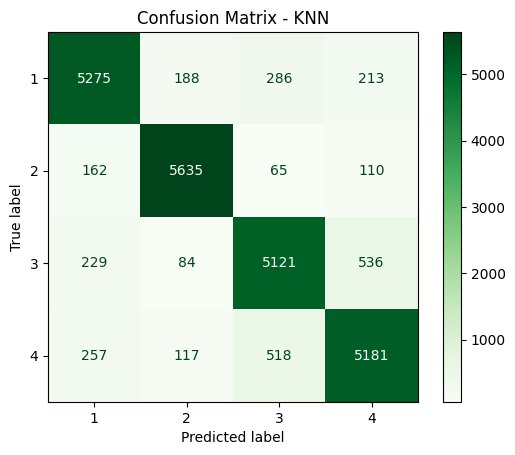

In [44]:
# KNN
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean', weights='distance')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
# Accuracy
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
# Classification Report
print(classification_report(y_test, y_pred_knn))
# Confusion Matrix - KNN
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=sorted(y.unique()))
plt.figure(figsize=(6,5))
disp_knn.plot(cmap='Greens', values_format='d')
plt.title('Confusion Matrix - KNN')
plt.show()

In [45]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [46]:
# Prediction
y_pred_nb = nb.predict(X_test)

In [47]:
# Accuracy
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.893356132960754


In [48]:
# Classification Report
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           1       0.90      0.89      0.90      5962
           2       0.94      0.97      0.96      5972
           3       0.86      0.85      0.86      5970
           4       0.86      0.86      0.86      6073

    accuracy                           0.89     23977
   macro avg       0.89      0.89      0.89     23977
weighted avg       0.89      0.89      0.89     23977



<Figure size 600x500 with 0 Axes>

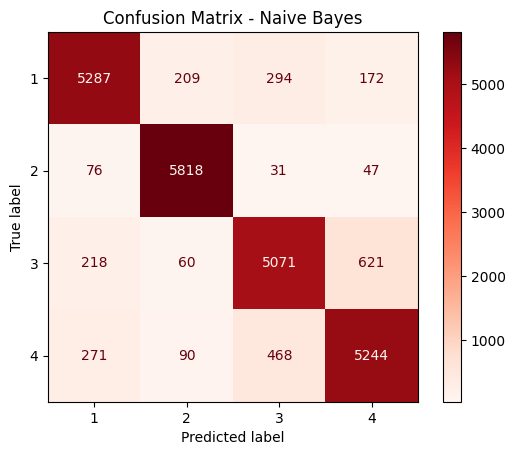

In [49]:
# Confusion Matrix - Naive Bayes
cm_nb = confusion_matrix(y_test, y_pred_nb)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=sorted(y.unique()))
plt.figure(figsize=(6,5))
disp_nb.plot(cmap='Reds', values_format='d')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

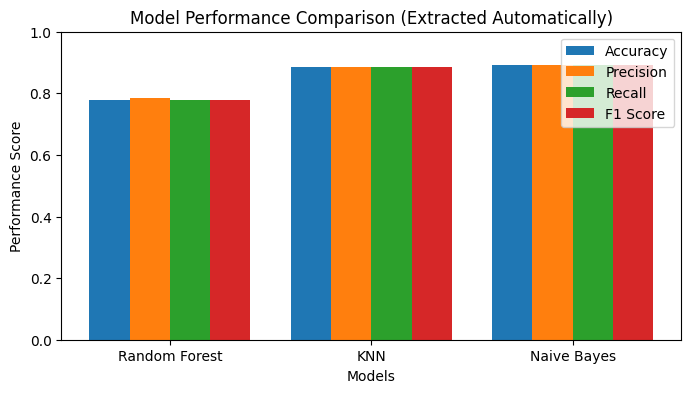

In [50]:
# Generate classification reports
report_rf = classification_report(y_test, y_pred_rf, output_dict=True)
report_knn = classification_report(y_test, y_pred_knn, output_dict=True)
report_nb = classification_report(y_test, y_pred_nb, output_dict=True)

# Extract macro-average metrics directly
models = ['Random Forest', 'KNN', 'Naive Bayes']

accuracy = [
    report_rf['accuracy'],
    report_knn['accuracy'],
    report_nb['accuracy']
]

precision = [
    report_rf['macro avg']['precision'],
    report_knn['macro avg']['precision'],
    report_nb['macro avg']['precision']
]

recall = [
    report_rf['macro avg']['recall'],
    report_knn['macro avg']['recall'],
    report_nb['macro avg']['recall']
]

f1 = [
    report_rf['macro avg']['f1-score'],
    report_knn['macro avg']['f1-score'],
    report_nb['macro avg']['f1-score']
]

# Comparison
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(8,4))

plt.bar(x - 1.5*width, accuracy, width, label='Accuracy')
plt.bar(x - 0.5*width, precision, width, label='Precision')
plt.bar(x + 0.5*width, recall, width, label='Recall')
plt.bar(x + 1.5*width, f1, width, label='F1 Score')

plt.xlabel('Models')
plt.ylabel('Performance Score')
plt.title('Model Performance Comparison (Extracted Automatically)')
plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.legend()

plt.show()
